In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import time

In [2]:
script_dir = Path().resolve()
audio_file = script_dir / '../../../test/audio/recorded/techno_loop.wav'

In [3]:
# extract mfccs with standard library
import essentia.standard as es
import essentia

start_time = time.time()

audio = es.MonoLoader(filename=str(audio_file))()
windowing = es.Windowing(type='blackmanharris62', zeroPadding=2048)
spectrum = es.Spectrum()
mfcc = es.MFCC()
log_norm = es.UnaryOperator(type='log')

amp2db = es.UnaryOperator(type='lin2db', scale=2)
pool = essentia.Pool()

for frame in es.FrameGenerator(audio, frameSize=2048, hopSize=1024):
    frame_spectrum = spectrum(windowing(frame))
    mfcc_bands, mfcc_coeffs = mfcc(frame_spectrum)

    pool.add('spectrum', amp2db(frame_spectrum))
    pool.add('mfcc_bands', mfcc_bands)
    pool.add('mfcc_coeffs', mfcc_coeffs)
    pool.add('log_mfcc_bands', log_norm(mfcc_bands))

print(f"execution time: {time.time() - start_time:.3f}[s]")


execution time: 0.213[s]


[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


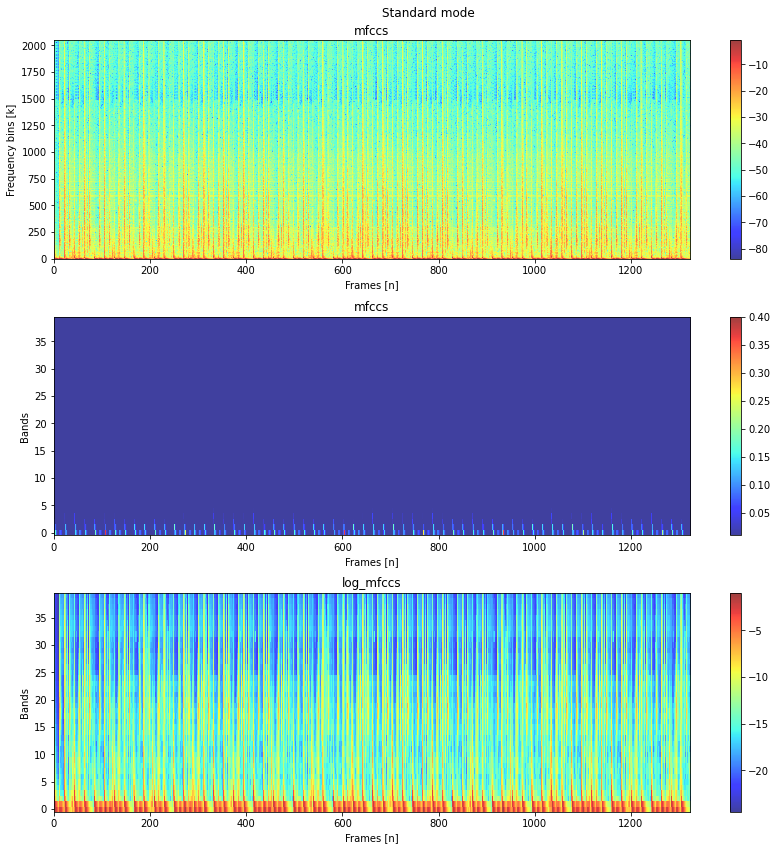

In [4]:
# display standard descriptors
fig, ax = plt.subplots(figsize=(12, 12), nrows=3)

ax0_plot = ax[0].imshow(
        pool["spectrum"].T,
        aspect = 'auto',
        origin='lower',
        interpolation='none',
        cmap="jet",
        alpha=0.75
        )
ax[0].set_title("mfccs")
ax[0].set_xlabel("Frames [n]")
ax[0].set_ylabel("Frequency bins [k]")

ax1_plot = ax[1].imshow(
        pool["mfcc_bands"].T,
        aspect = 'auto',
        origin='lower',
        interpolation='none',
        cmap="jet",
        vmin=0.01,
        vmax=0.4,
        alpha=0.75
        )
ax[1].set_title("mfccs")
ax[1].set_xlabel("Frames [n]")
ax[1].set_ylabel("Bands")

ax2_plot = ax[2].imshow(
        pool["log_mfcc_bands"].T,
        aspect = 'auto',
        origin='lower',
        interpolation='none',
        cmap="jet",
        alpha=0.75
        )
ax[2].set_title("log_mfccs")
ax[2].set_xlabel("Frames [n]")
ax[2].set_ylabel("Bands")

plt.colorbar(ax0_plot,ax=ax[0])
plt.colorbar(ax1_plot,ax=ax[1])
plt.colorbar(ax2_plot,ax=ax[2])

plt.suptitle("Standard mode")
plt.tight_layout()
plt.show()

Let's do the same but now in streaming mode...

In [5]:
# extract mfccs with streaming library
import essentia.streaming as ess

start_time = time.time()

loader = ess.MonoLoader(filename=str(audio_file))
frameCutter = ess.FrameCutter(frameSize = 2048, hopSize = 1024)
windowing = ess.Windowing(type='blackmanharris62', zeroPadding=2048)
spectrum = ess.Spectrum()
mfcc = ess.MFCC()
log_norm = ess.UnaryOperator(type='log')
amp2db = ess.UnaryOperator(type='lin2db', scale=2)
pool = essentia.Pool()

loader.audio >> frameCutter.signal
frameCutter.frame >> windowing.frame >> spectrum.frame
spectrum.spectrum >> mfcc.spectrum

spectrum.spectrum >> amp2db.array
amp2db.array >> (pool, 'lowlevel.spectrum')

mfcc.bands >> (pool, 'lowlevel.mfcc_bands')
mfcc.mfcc >> (pool, 'lowlevel.mfcc')

mfcc.bands >> log_norm.array
log_norm.array >> (pool, 'lowlevel.log_mfcc_bands')

essentia.run(loader)
print(f"execution time: {time.time() - start_time:.3f}")

print(f"Pool contains the following descriptors: {pool.descriptorNames()}[s]")

execution time: 0.105
Pool contains the following descriptors: ['lowlevel.log_mfcc_bands', 'lowlevel.mfcc', 'lowlevel.mfcc_bands', 'lowlevel.spectrum'][s]


[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


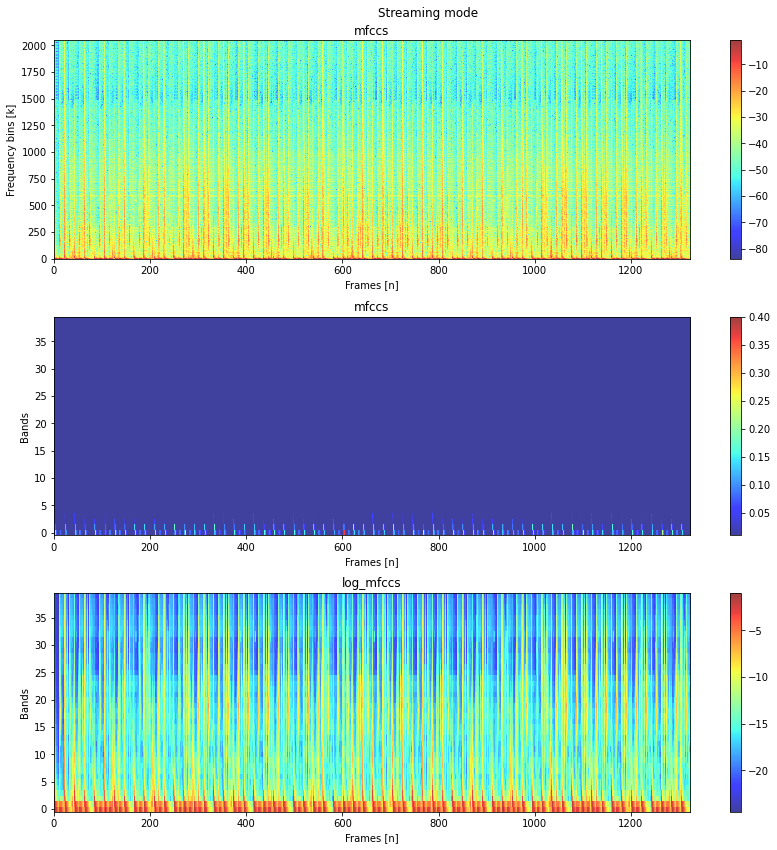

In [6]:
# display streaming descriptors
fig, ax = plt.subplots(figsize=(12, 12), nrows=3)

ax0_plot = ax[0].imshow(
        pool["lowlevel.spectrum"].T,
        aspect = 'auto',
        origin='lower',
        interpolation='none',
        cmap="jet",
        alpha=0.75
        )
ax[0].set_title("mfccs")
ax[0].set_xlabel("Frames [n]")
ax[0].set_ylabel("Frequency bins [k]")

ax1_plot = ax[1].imshow(
        pool["lowlevel.mfcc_bands"].T,
        aspect = 'auto',
        origin='lower',
        interpolation='none',
        cmap="jet",
        vmin=0.01,
        vmax=0.4,
        alpha=0.75
        )
ax[1].set_title("mfccs")
ax[1].set_xlabel("Frames [n]")
ax[1].set_ylabel("Bands")

ax2_plot = ax[2].imshow(
        pool["lowlevel.log_mfcc_bands"].T,
        aspect = 'auto',
        origin='lower',
        interpolation='none',
        cmap="jet",
        alpha=0.75
        )
ax[2].set_title("log_mfccs")
ax[2].set_xlabel("Frames [n]")
ax[2].set_ylabel("Bands")

plt.colorbar(ax0_plot,ax=ax[0])
plt.colorbar(ax1_plot,ax=ax[1])
plt.colorbar(ax2_plot,ax=ax[2])

plt.suptitle("Streaming mode")
plt.tight_layout()
plt.show()